<a href="https://colab.research.google.com/github/yeedacoding/TensorFlow-Tutorial/blob/main/tf_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

2.6.0


# IMDB 데이터셋 다운로드

In [2]:
# IMDB 데이터셋 다운로드

imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)
# num_words = 10000 은 훈련 데이터에서 가장 많이 등장하는 상위 10000개의 단어

17473536/17464789 [==============================] - 0s 0us/step


In [6]:
# 데이터 형태 살펴보기
# IMDB 데이터셋의 샘플은 전처리된 정수 배열 -> 정수는 영화 리뷰에 나오는 단어
# 레이블은 정수 0 또는 1 -> 0 = 부정적 리뷰, 1 = 긍정적 리뷰

print("훈련 샘플 : {}, 레이블 : {}".format(len(train_data), len(train_labels)))
print("테스트 샘플 : {}, 레이블 : {}".format(len(test_data), len(test_labels)))

훈련 샘플 : 25000, 레이블 : 25000
테스트 샘플 : 25000, 레이블 : 25000


In [9]:
# 리뷰 텍스트는 어휘 사전의 특정 단어를 나타내는 정수로 변환되어 있음
# 첫번째 훈련 데이터에 들어있는 리뷰 텍스트

print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [10]:
# 당연히 모든 데이터(리뷰 텍스트)의 길이는 다름
# 신경망의 입력은 길이가 같아야 하기 때문에 이 문제를 해결해야 함

len(train_data[0]), len(train_data[1])

(218, 189)

In [13]:
# 정수를 다시 단어로 변환하기
# 정수와 문자열을 매핑한 딕셔너리(dictionary) 객체에 질의하는 헬퍼(helper)함수를 만들어보기

# 단어와 정수 인덱스를 매핑한 딕셔너리
word_index = imdb.get_word_index()

# 처음 몇 개 인덱스는 사전에 정의되어 있음
word_index = {k : (v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<STAR>"] = 1
word_index["<UNK>"] = 2 #UNKOWN
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text) :
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [14]:
decode_review(train_data[0])

"<STAR> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wha

# 데이터 준비

In [15]:
# 리뷰(정수 배열)는 신경망에 주입하기 전에 텐서로 변환되어야 함
# 1. 원-핫 인코딩(one-hot encoding) = 정수 배열을 0과 1로 이루어진 벡터로 변환
# 2. 정수 배열의 길이가 모두 같도록 패딩(padding)을 추가해 max_length * num_reviews 크기의 정수 텐서를 만듦

# 모든 영화 리뷰의 길이가 같아야 하므로 pad_sequences함수를 사용해 길이 맞추기

train_data = keras.preprocessing.sequence.pad_sequences(train_data, 
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [16]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [18]:
print(train_data[0])

# 빈 배열은 0이 되는구나

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

# 모델 구성

In [19]:
# 역시 신경망은 layer를 쌓아서 만드네
# 고려사항
# 1. 모델에서 얼마나 많은 층을 사용할 것인가?
# 2. 각 층에서 얼마나 많은 은닉 유닛(hidden unit)을 사용할 것인가?
# 이 예제의 입력 데이터 = 단어 인덱스의 배열
# 레이블 = 0 또는 1

# 입력 크기는 영화 리뷰 데이터셋에 적용된 어휘 사전의 크기(10000개의 단어)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None, )))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [20]:
# 모델에 사용할 optimizer 와 loss function 설정

model.compile(optimizer = 'adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [21]:
# 검증 세트 만들기
# 기존 train_data에서 10000개의 샘플을 떼어내어 검증 세트(validation set)를 만들기
# test_data를 사용하지 않는 이유 = train_data만을 사용하여 모델을 개발하고 튜닝하는 것이 목표

x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

# 모델 훈련

In [22]:
# 512개의 샘플로 이루어진 미니배치에서 40번의 에포크 동안 훈련
# x_train과 y_train 텐서에 있는 모든 샘플에 대해 40번 반복한다는 뜻

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data = (x_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 25ms/step - loss: 0.6922 - accuracy: 0.5451 - val_loss: 0.6907 - val_accuracy: 0.6284
Epoch 2/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6875 - accuracy: 0.7005 - val_loss: 0.6836 - val_accuracy: 0.7156
Epoch 3/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6760 - accuracy: 0.6974 - val_loss: 0.6687 - val_accuracy: 0.7564
Epoch 4/40
30/30 [==============================] - 1s 20ms/step - loss: 0.6547 - accuracy: 0.7601 - val_loss: 0.6436 - val_accuracy: 0.7675
Epoch 5/40
30/30 [==============================] - 1s 19ms/step - loss: 0.6227 - accuracy: 0.7903 - val_loss: 0.6095 - val_accuracy: 0.7892
Epoch 6/40
30/30 [==============================] - 1s 19ms/step - loss: 0.5815 - accuracy: 0.8098 - val_loss: 0.5689 - val_accuracy: 0.8000
Epoch 7/40
30/30 [==============================] - 1s 20ms/step - loss: 0.5351 - accuracy: 0.8303 - val_loss: 0.5260 - val_accuracy: 0.8188
Epoch 8/40
30

# 모델 평가

In [23]:
# 모델 성능 확인하기
# 손실값과 정확도 반환 (손실=오차이므로 숫자가 낮을수록 좋음)

results = model.evaluate(test_data, test_labels, verbose=2)

print(results)

782/782 - 1s - loss: 0.3266 - accuracy: 0.8729
[0.3265581429004669, 0.8729199767112732]


# 정확도와 손실 그래프 그리기

In [24]:
# model.fit()는 history객체를 반환
# history에는 훈련하는 동안 일어난 모든 정보가 담긴 딕셔너리가 들어있음

history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

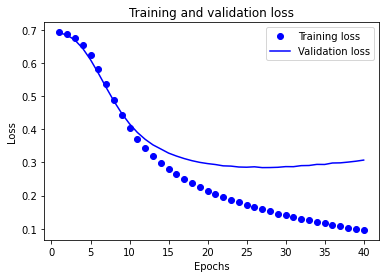

In [29]:
# 훈련손실, 검증손실 그래프와 훈련 정확도, 검증정확도 그래프를 그려서 비교하기
# 점선 = 훈련손실, 훈련정확도
# 실선 = 검증손실, 검증정확도

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#'bo' = '파란색 점
# 'b' = '파란 실선'
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

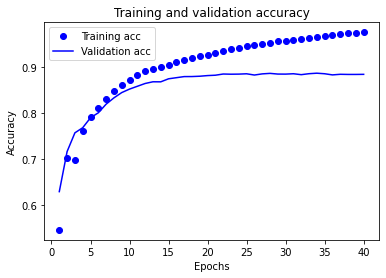

In [30]:
plt.clf()  # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()